In [49]:
import glob

input_dir = r'D:\dataset\segment_data\images\images'
target_dir = r'D:\dataset\segment_data\annotations\annotations\trimaps'
img_size = (160, 160)
num_classes = 3
batch_size = 32


In [50]:
# get train data list
input_img_paths = glob.glob(f"{input_dir}\*.jpg")
target_img_paths = glob.glob(f'{target_dir}\*.png')

print('Number of samples:', len(input_img_paths))

Number of samples: 7390


In [7]:
# # make a tf dataset

# import tensorflow as tf

# tf.data.Dataset.from_tensor_slices()


TypeError: from_tensor_slices() missing 1 required positional argument: 'tensors'

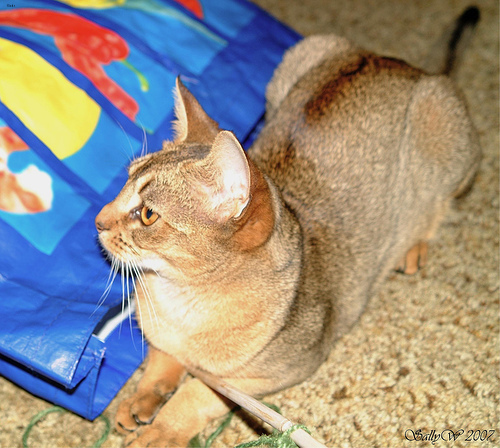

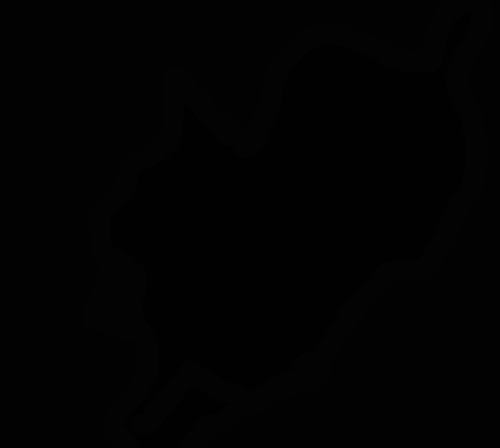

In [52]:
# visualize data

from IPython.display import display
import PIL 
import cv2
display(PIL.Image.open(input_img_paths[9]))
img = PIL.Image.open(target_img_paths[9])
display(img)

In [31]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class oxfordPets(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')

        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) +self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode = 'grayscale')
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y
    

In [16]:
import keras.layers as layers

def separable_conv_block(input, filters):
    x = layers.Activation('relu')(input)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x

def upsampling_block(input, filters):
    x = layers.Activation('relu')(input)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    

def residual_block(input, filters):

    x = separable_conv_block(input, filters)
    x = separable_conv_block(x, filters)
    x = layers.MaxPooling2D(3, strides = 2, padding='same')(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(input)

    x = layers.add([x, residual])
    return x


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    for filters in [64, 128, 256]:
        x = residual_block(x, filters)

    previous_block_activation = x
    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs, outputs)

    return model


In [17]:
keras.backend.clear_session()

model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [32]:
import random

# make a dataset pipeline
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


train_gen = oxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)

val_gen = oxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [34]:
# train the model

model.compile(optimizer='rmsprop',  loss = 'sparse_categorical_crossentropy')

callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)
]

epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 66s 310ms/step - loss: 0.2390 - val_loss: 0.4506
Epoch 2/15
199/199 [==============================] - 65s 328ms/step - loss: 0.2210 - val_loss: 0.4111
Epoch 3/15
199/199 [==============================] - 56s 279ms/step - loss: 0.2114 - val_loss: 0.4583
Epoch 4/15
199/199 [==============================] - 55s 274ms/step - loss: 0.2015 - val_loss: 0.4474
Epoch 5/15
199/199 [==============================] - 55s 276ms/step - loss: 0.1911 - val_loss: 0.4154
Epoch 6/15
199/199 [==============================] - 55s 276ms/step - loss: 0.1830 - val_loss: 0.4062
Epoch 7/15
199/199 [==============================] - 55s 276ms/step - loss: 0.1764 - val_loss: 0.4527
Epoch 8/15
199/199 [==============================] - 56s 281ms/step - loss: 0.1702 - val_loss: 0.4138
Epoch 9/15
199/199 [==============================] - 55s 274ms/step - loss: 0.1632 - val_loss: 0.4302
Epoch 10/15
199/199 [==============================] - 68s 343ms/step - l

31/31 [==============================] - 5s 167ms/step


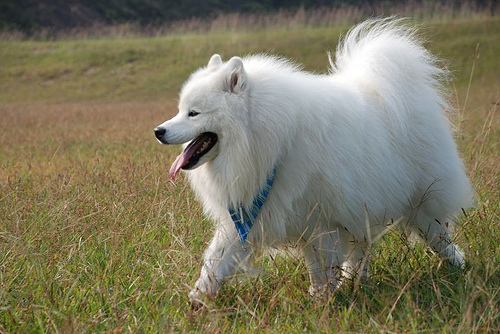

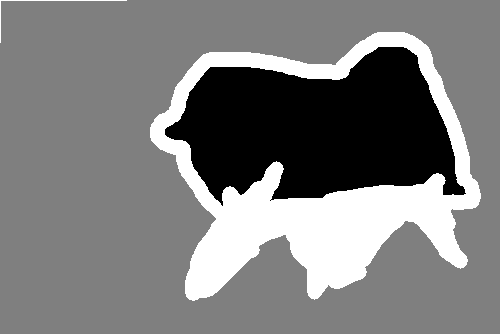

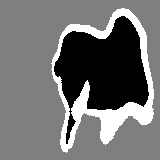

In [36]:
val_gen = oxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

i = 10

display(PIL.Image.open(val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)
